# Working out if we can tractably perform optimality experiments with the effective radius of a knn graph vs. number of samples vs. testing out if we get an interesting probability.

Given runtime (and sometimes space) constraints on compute cluster, we can only build knn-graphs with ~500 neighbors (see notes on some quick `kgraph` tests).

This notebook is to do some sanity experiments and calculations to ensure that these experiments are runnable. We do the following:

- [x] Graph/table the Sauer-Shelah bound curve to see how many samples are required to hit certain probabilities.  

- [ ] Run the KNN version of the PRM a certain number of times to determine the concentration of the effective connection radius for varying numbers of sampling (in the exact environment we intend to run them in).

We'll compare these results and draw some conclusions at the end of the document.

In [12]:
%cd ~/Research/nonasymptotic-mp
import time
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True})

from nonasymptotic.bound import *
from nonasymptotic.envs import StraightLine
from nonasymptotic.prm import SimpleNearestNeighborRadiusPRM

seed = 1999

/home/seiji/Research/nonasymptotic-mp


Dimensions correspond with common robot DofS (planar, planar + angle, arm on base, two arms, PR2).

In [13]:
# Specify the dimensions and sample counts we intend to test (only add in the 1e5/1e6 if we run this on supercloud).
ds = np.array([2, 3, 6, 7, 10, 14, 20])
sample_counts = np.array([1e2, 1e3, 1e4], dtype=np.int32)  # int(1e5), int(1e6) 

We'll be conducting these sanity-checking experiments in the exact environment we'll be evaluating them in: simple box environments $[-0.5, 1.5] \times [-0.5, 0.5]^{d-1}$, (we chose $\delta = 0.5$ so that the volume of the whole environment does not change between dimensions).

In [14]:
# construct environments
clearance = 0.5
envs = [StraightLine(_d, clearance, seed) for _d in ds]

Since these are optimality experiments, we should get a numerical sense of the $\epsilon \mapsto r_{conn}$ mapping. It is important to note that we lose 1-to-1 mapping when we shoot past 1 ($\epsilon$ is really only meant to be small, e.g. $<1$), so that's why we do this range. 

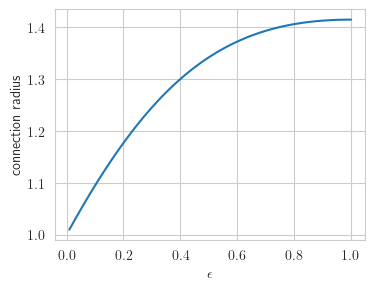

In [25]:
tols = np.linspace(1.0, 0.01, num=100)
conn_rads = compute_connection_radius(clearance, tols)

plt.figure(figsize=(4, 3))
plt.plot(tols, conn_rads)
plt.xlabel('$\epsilon$')
plt.ylabel('connection radius')
plt.show()

So we're looking to have connection radii between the $[1, \approx 1.4]$ range. But really, if the (effective) connection radius, we're in trouble.

Next, we'll zoom in on the kinds of $\epsilon$-nets we need to have, and how many samples (as predicted by Sauer-Shelah) we need to hit them (with an interesting range of hittable probabilities).

First (since this is a dimension-free quantity) -- the radius of the balls on the $\epsilon$-nets.

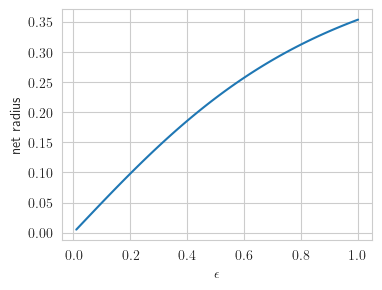

In [26]:
net_rads = compute_epsilon_net_radius(clearance, tols)

plt.figure(figsize=(4, 3))
plt.plot(tols, net_rads)
plt.xlabel('$\epsilon$')
plt.ylabel('net radius')
plt.show()

This looks tiny... a bit worried here. But we press on to find out.

We first compute the required rhos for each dimension, and then we zoom in (interesting ranges) of Sauer-Shelah.

<Figure size 640x480 with 0 Axes>

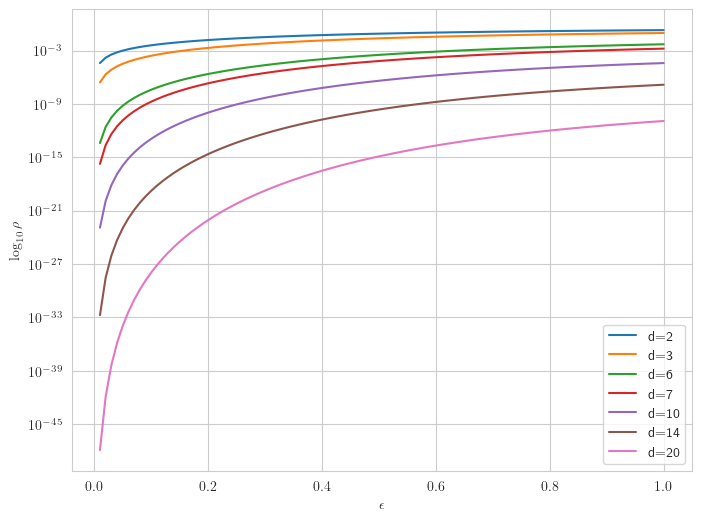

In [27]:
vols_env = np.array([_e.volume for _e in envs])

# we could probably vectorize in a meshgrid, but for sanity, we just do dimension-by-dimension

rhos = []
for _d, _vol_env in zip(ds, vols_env):
    rhos.append(compute_rho(clearance, tols, _d, _vol_env))

rhos = np.array(rhos)

plt.figure()
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_ylabel('$\log_{10} \\rho$')
for _rhos_d, _d in zip(rhos, ds):
    ax.plot(tols, _rhos_d, label='d={}'.format(_d))
    
ax.set_xlabel('$\epsilon$')
ax.set_yscale('log')
plt.legend()
plt.show()

## VC/Sauer-Shelah bound, plotted at last
Plotting the required samples at different probability bands (objective 1!).

In [35]:
# computing and plotting the interesting ranges of Sauer-Shelah for each dimension
# indexing layout of the record array: [success_probs] X [epsilons<->rho] -> sample_required

success_probs = np.array([1e-2, 0.1, 0.5, 0.9, 0.99])

def _partition_curves_into_equal_chunks(_x_indices, _y_curves, n_chunks=5):
    _n_points = len(_x_indices)
    _nominal_length = np.floor(_n_points / n_chunks).astype('int')
    
    # include extra bits into the first chunks, because that's where the least increase happens
    #   so influences the plot yscale the easiest
    _extra_length = _n_points - _nominal_length * n_chunks 
    
    _domains = [] 
    _ranges = []

    _cur_i = _nominal_length + _extra_length 
    _domains.append(_x_indices[:_cur_i]) 
    _ranges.append(_y_curves[:, :_cur_i])
   
    for _i in range(1, n_chunks):
        _next_i = _cur_i + _nominal_length
        
        _domains.append(_x_indices[_cur_i:_next_i])
        _ranges.append(_y_curves[:, _cur_i:_next_i])
        
        _cur_i = _next_i 
    
    return _domains, _ranges
        
def _initialize_plot_for_curve_ranges(_data_domains, _data_ranges, _range_labels):
    _n_plots = len(_data_ranges)
    fig, axes = plt.subplots(nrows=_n_plots, ncols=1, figsize=(5, 4 * _n_plots))
    
    if _n_plots == 1:
        axes = [axes]
         
        
    for _i_ax, _ax in enumerate(axes):
        for _i_rl, _rl in enumerate(_range_labels):
            _ax.plot(_data_domains[_i_ax], _data_ranges[_i_ax][_i_rl, :], label='p=%f' % _rl)
        
        _ax.legend()
        
    return fig, axes


Python computation slows down with $\rho \lessapprox 1\mathrm e -10$. 

computing 2
finished 2
computing 3
finished 3
computing 6
finished 6
computing 7
finished 7
computing 10
finished 10
computing 14
finished 14
computing 20
finished 20


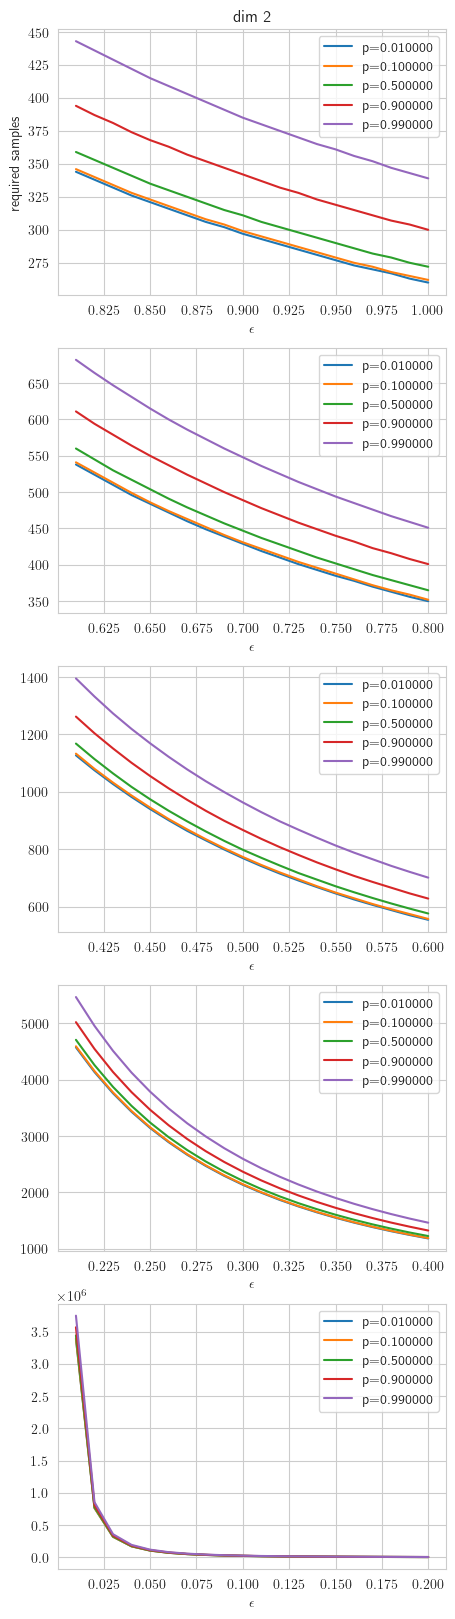

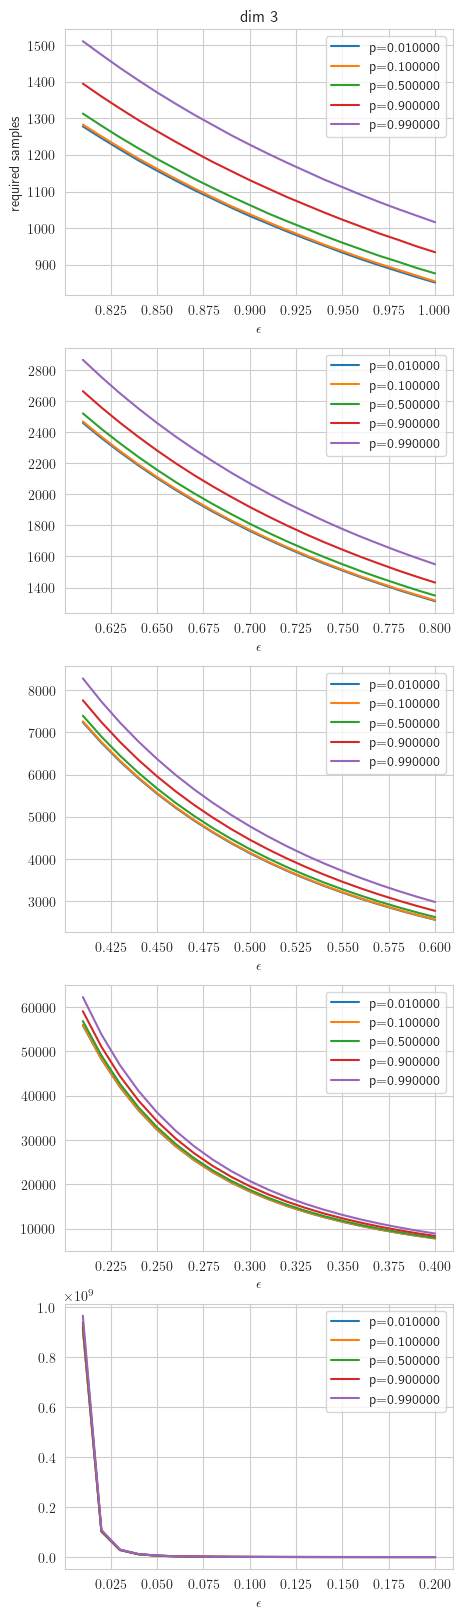

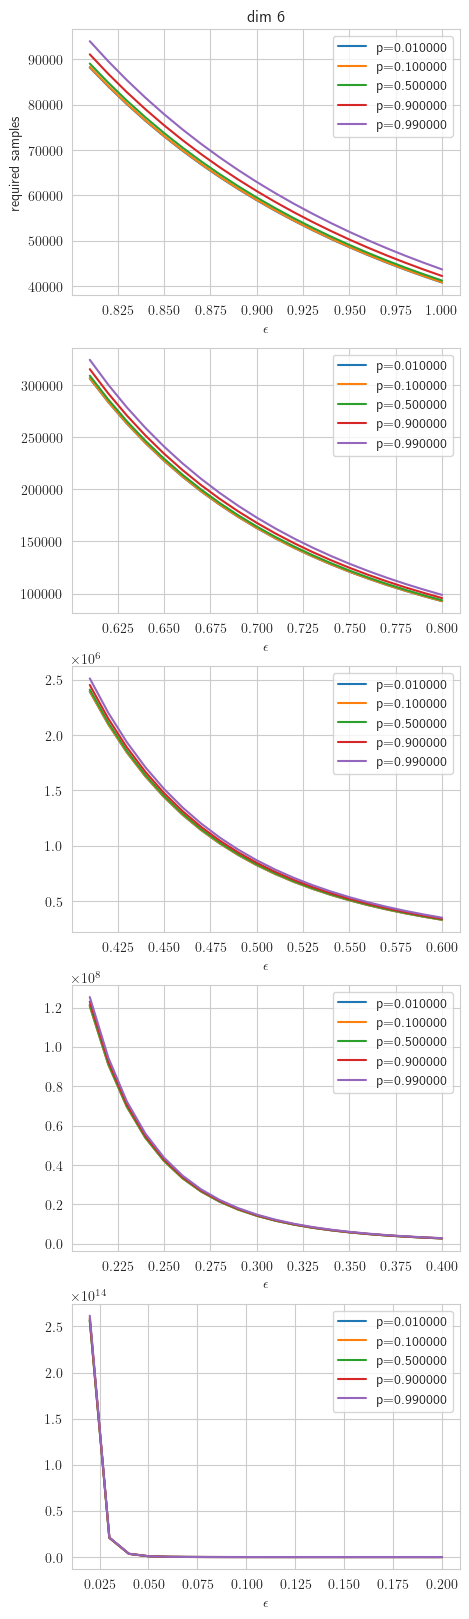

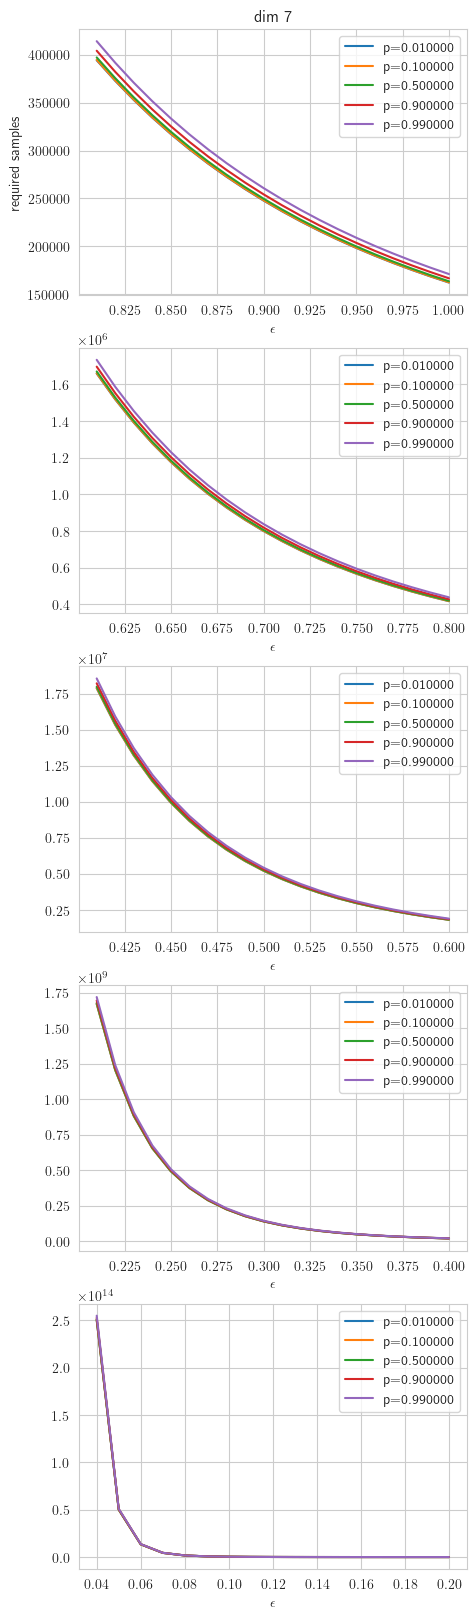

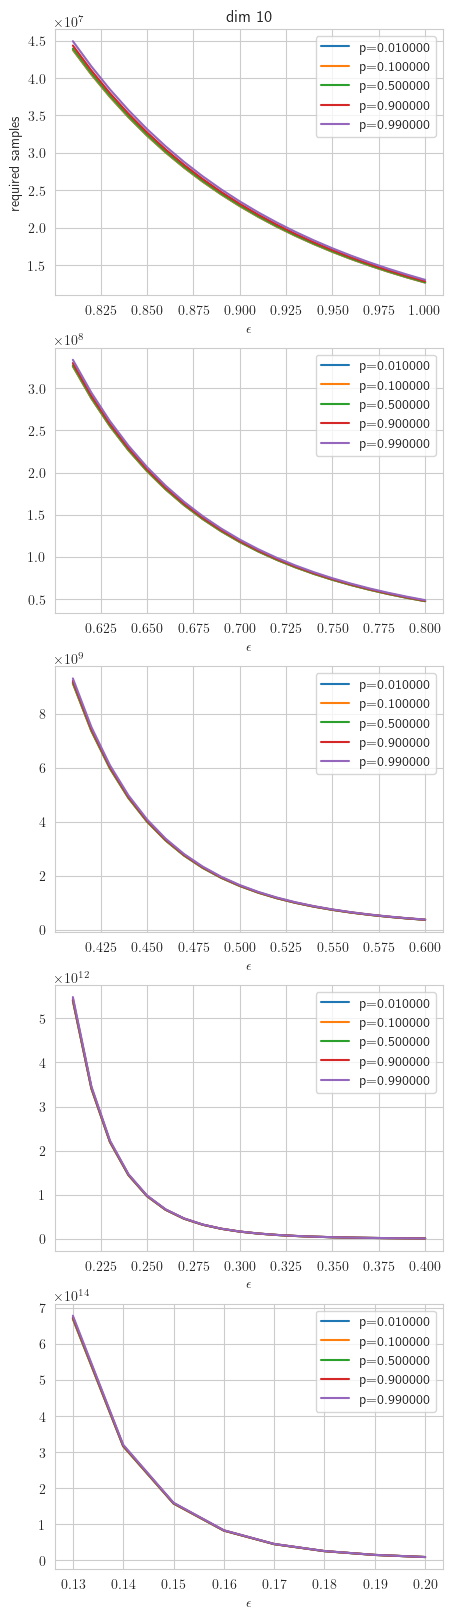

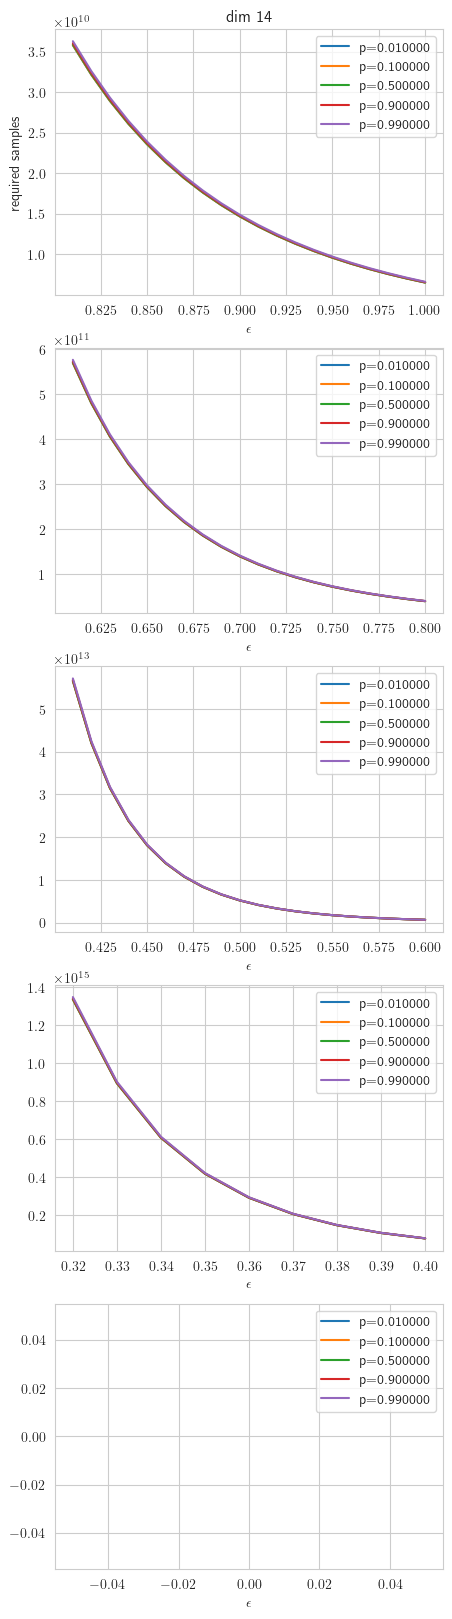

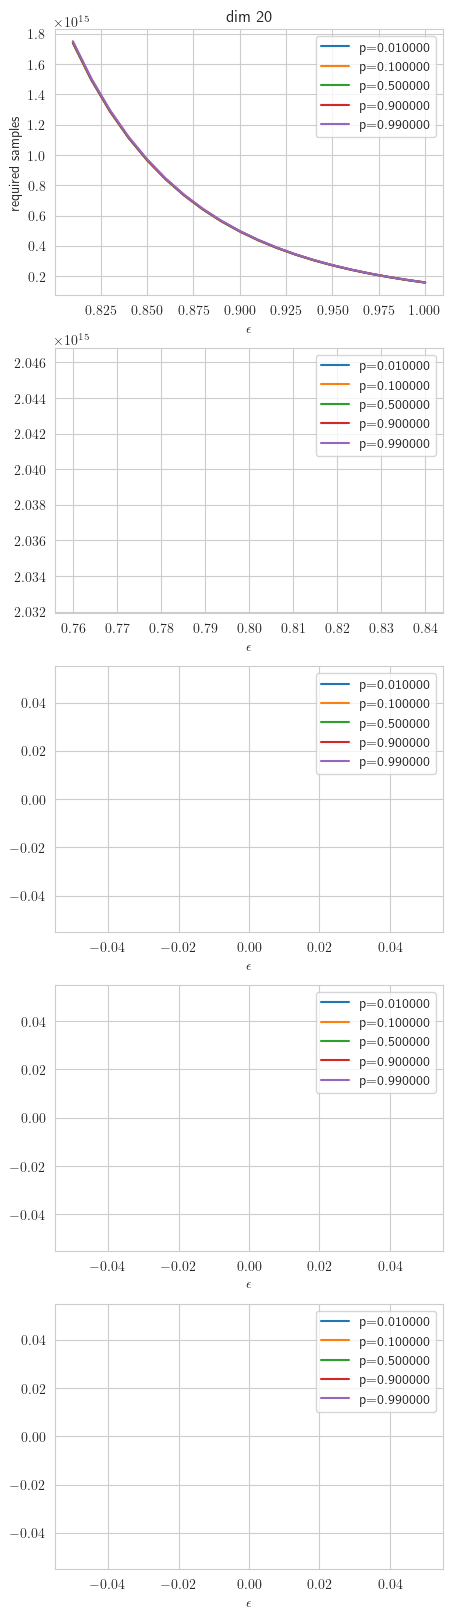

In [36]:
rho_thresh = 1e-12

required_samples = np.zeros((len(ds), len(success_probs), len(tols)))
required_samples[:, :, :] = np.nan # skip these points in plotting unless filled otherwise.

# (the bound computation is woefully unvectorized, which is why we have to do this)
for i_d, _d in enumerate(ds):
    print('computing %i' % _d)
    _vc = _d + 1
    for i_sp, _sp in enumerate(success_probs):
        for i_rho, _rho in enumerate(rhos[i_d]):
            # print('rho: %.16f' % _rho)
            if _rho < rho_thresh:
                continue
                
            required_samples[i_d, i_sp, i_rho] = doubling_search_over_sauer_shelah(_rho, _vc, _sp)
    print('finished %i' % _d)

for _rs, _d in zip(required_samples, ds):
    domain_chunks, range_chunks = _partition_curves_into_equal_chunks(tols, _rs) 
    _, axes = _initialize_plot_for_curve_ranges(domain_chunks, range_chunks, success_probs)
    [ax.set_xlabel('$\epsilon$') for ax in axes]
    axes[0].set_ylabel('required samples')
    axes[0].set_title('dim %i' % _d)
    plt.show()        


In [15]:
# zombie code (may come back again!)

# def _partition_curves_into_readable_ranges(_xindices, _ycurves, thresh=1e3):
#     # we operate on the last curve, since it's set up to be the most extreme
#     # we also assume that curves are in ascending order (tol goes down... rho goes down... 
#     #   number of samples goes up)
#     assert _ycurves.shape[1] == len(_xindices)
# 
#     _data_domains = []
#     _data_ranges = [] 
# 
#     _i = 0
#     while True:
#         _i_val = _ycurves[-1, _i]
#         _ip1 = np.searchsorted(_ycurves[-1, :], _i_val + thresh, side='right')
# 
#         _data_ranges.append(_ycurves[:, _i:_ip1])
#         _data_domains.append(_xindices[_i:_ip1])
# 
#         if _ip1 >= _ycurves.shape[1] - 1:
#             return _data_domains, _data_ranges
# 
#         _i = _ip1 
# 
# 
# def _compute_samples_per_success_probs_and_tols(_d, _sps, _rhos):
#     _required_samples = np.zeros((len(_sps), len(_rhos)))
# 
#     _vc = _d + 1
#     for i_sp, _sp in enumerate(_sps):
#         for i_rho, _rho in enumerate(_rhos):
#             _required_samples[i_sp, i_rho] = doubling_search_over_sauer_shelah(_rho, _vc, _sp)
# 
#     return _required_samples
# def _one_dimension_iteration(_d, _sps, _rhos, chunks=5):
#     _i_d = np.searchsorted(ds, _d, side='left')
#     assert _d == ds[_i_d], "ds must contain passed dim: %i" % _d
# 
#     _rs = _compute_samples_per_success_probs_and_tols(_d, _sps, _rhos[_i_d])
#     _domains, _ranges = _partition_curves_into_equal_chunks(tols, _rs, n_chunks=chunks)
#     fig, axes = _initialize_plot_for_curve_ranges(_domains, _ranges, _sps)
# 
#     axes[0].set_ylabel('required samples')
#     axes[0].set_title('dim %i' % _d)
#     for _ax in axes:
#         _ax.set_xlabel('$\epsilon$')
# 
#     plt.show()